# Radial Basis Functions Neural Networks
A RBF network is an alternative to a Feedforward neural network, and it mixes ideas from unsupervised and supervised learning. A RBF network for a C classes classification problem is based on K prototypes, such that the classification depends on the __distance__ between the point and the K prototypes. A RBF network consists in 3 layers as shown in the following [figure](https://mccormickml.com/2013/08/15/radial-basis-function-network-rbfn-tutorial/):

<p align="center">
  <img src="../imgs/architecture_simple2.png"/ width=50%>
</p>



The distance between an input sample x and a prototype $\mu_i$ is given by a Radial Basis Function (i.e. a function that depends on the distance). One of the most used is the Gaussian radial basis function:
$$
\phi(x) = e^{-\beta||x-\mu||^2}
$$
It is similar to the normal distribution, but we are ignoring the normalization term because we do not need that it sums to one. The [figure](http://chrisjmccormick.files.wordpress.com/2013/08/diff_variances_plot.png) shows the Gaussian RBF with $\mu = 0$ and different values of $\beta$:
<p align="center">
  <img src="../imgs/diff_variances_plot.png"/ width=50%>
</p>


In [1]:
from typing import Any
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
from sklearn.utils import shuffle

The picture below illustrates the computational graph, that is then implemented in PyTorch
<p align="center">
  <img src="../imgs/rbf.png"/ width=50%>
</p>

In [2]:


class RBFNeuralNetwork(nn.Module):
    def __init__(self,in_features:int,n_prototypes:int,n_classes:int):
        
        super().__init__()
        self.proto = torch.nn.Parameter(
            torch.randn(size=(1,n_prototypes,in_features),dtype=torch.float32))
        self.betas = torch.nn.Parameter(
            torch.rand(size=(1,n_prototypes)))
        self.linear = nn.Linear(in_features=n_prototypes,out_features=n_classes)
        
    def __call__(self,x) -> Any:
        x = torch.unsqueeze(x,1)
        o = x-self.proto
        o = torch.pow(o,2)
        o = torch.sum(o,dim=-1,keepdim=False)
        o = torch.exp(-self.betas*o)
        o = self.linear(o)
        return o

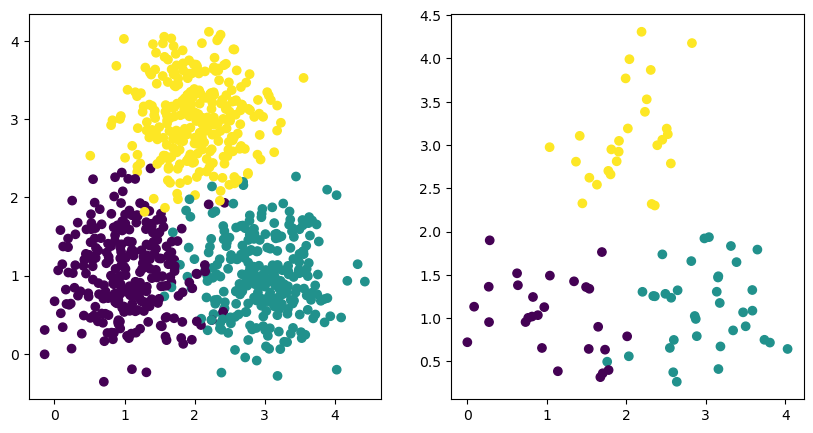

In [3]:
N = 900
K = 3
m1 = [1.,1.]
m2 = [3.,1.]
m3 = [2.,3.]
cov = np.asarray(
    [[.5, .0],
     [.0, .5]])
cov = cov @ np.transpose(cov)
X_1 = np.random.multivariate_normal(mean=m1,cov=cov,size=N//3)
X_2 = np.random.multivariate_normal(mean=m2,cov=cov,size=N//3)
X_3 = np.random.multivariate_normal(mean=m3,cov=cov,size=N//3)

X = torch.tensor(np.concatenate([X_1,X_2,X_3],axis=0))
Y = torch.concat(
    [torch.zeros(X_1.shape[0],dtype=torch.int64),
     torch.ones(X_2.shape[0],dtype=torch.int64),
     2*torch.ones(X_3.shape[0],dtype=torch.int64)],dim=0)

# Shuffle
perm =torch.randperm(X.shape[0]) 
Y = nn.functional.one_hot(Y)
X = X[perm,...].type(torch.float32)
Y = Y[perm,...].type(torch.float32)

X_train = X[:-90,...]
Y_train = Y[:-90,...]
X_test = X[-90:,...]
Y_test = Y[-90:,...]

labels = torch.argmax(Y,dim=1,keepdim=False)
fig,ax = plt.subplots(1,2)
fig.set_size_inches(10,5)
ax[0].scatter(x=X_train[:,0],y=X_train[:,1],c=torch.argmax(Y_train,dim=1,keepdim=False))
ax[1].scatter(x=X_test[:,0],y=X_test[:,1],c=torch.argmax(Y_test,dim=1,keepdim=False))
plt.show()

In [4]:
BS = 8

trainset = TensorDataset(X_train,Y_train)
trainloader = DataLoader(trainset,batch_size=BS,shuffle=False)
valset = TensorDataset(X_test,Y_test)
valloader = DataLoader(valset,batch_size=BS,shuffle=False)

In [5]:
LR = 10**-2
EP = 200

net = RBFNeuralNetwork(
    in_features=2,
    n_prototypes=3,
    n_classes=3
).cuda()
opt = torch.optim.SGD(params=net.parameters(),lr=LR)
criterion = nn.CrossEntropyLoss()

In [6]:
from utils import train_classifier
trainloss,valloss = train_classifier(
    net,
    opt,
    trainloader,
    valloader,
    criterion,
    EP,
    model_name="rbfnn"
)

[1,    10] loss: 1.124
[1,    20] loss: 1.122
[1,    30] loss: 1.111
[1,    40] loss: 1.119
[1,    50] loss: 1.119
[1,    60] loss: 1.120
[1,    70] loss: 1.121
[1,    80] loss: 1.125
[1,    90] loss: 1.126
[1,   100] loss: 1.124
Validation Loss decreased, Saving
[2,    10] loss: 1.088
[2,    20] loss: 1.087
[2,    30] loss: 1.083
[2,    40] loss: 1.087
[2,    50] loss: 1.087
[2,    60] loss: 1.088
[2,    70] loss: 1.089
[2,    80] loss: 1.090
[2,    90] loss: 1.090
[2,   100] loss: 1.090
Validation Loss decreased, Saving
[3,    10] loss: 1.073
[3,    20] loss: 1.073
[3,    30] loss: 1.071
[3,    40] loss: 1.073
[3,    50] loss: 1.073
[3,    60] loss: 1.074
[3,    70] loss: 1.074
[3,    80] loss: 1.073
[3,    90] loss: 1.072
[3,   100] loss: 1.072
Validation Loss decreased, Saving
[4,    10] loss: 1.062
[4,    20] loss: 1.062
[4,    30] loss: 1.061
[4,    40] loss: 1.063
[4,    50] loss: 1.062
[4,    60] loss: 1.063
[4,    70] loss: 1.062
[4,    80] loss: 1.061
[4,    90] loss: 1.059
[

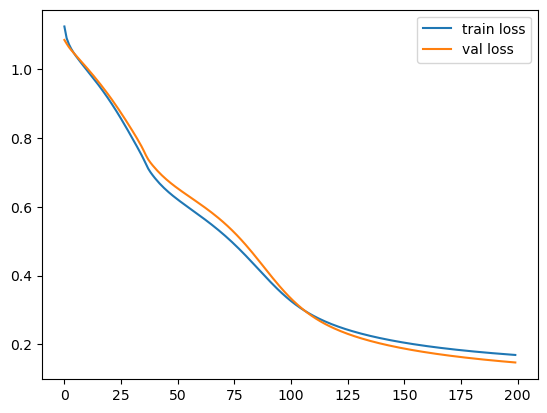

In [7]:

plt.plot(trainloss,label="train loss")
plt.plot(valloss,label="val loss")
plt.legend()
plt.show()

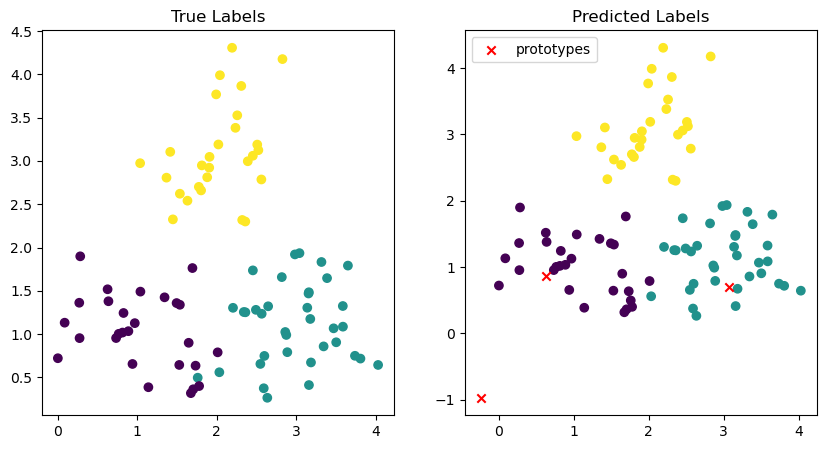

In [8]:
Y_pred = net(X_test.cuda()).cpu()
true_labels = torch.argmax(Y_test,dim=1,keepdim=False)
pred_labels = torch.argmax(Y_pred,dim=1,keepdim=False)

prototypes = net.proto[0,...].cpu().detach()
fig,ax = plt.subplots(1,2)
fig.set_size_inches(10,5)
ax[0].scatter(x=X_test[:,0],y=X_test[:,1],c=true_labels)
ax[0].set_title("True Labels")
ax[1].scatter(x=X_test[:,0],y=X_test[:,1],c=pred_labels)
ax[1].scatter(x=prototypes[:,0],y=prototypes[:,1],c="r",marker="x",label="prototypes")
ax[1].set_title("Predicted Labels")
plt.legend()
plt.show()

Now we consider the example dataset that we used in the [notebook](./10neural_networks.ipynb) about feed forward neural networks. In particular we used a network with 1 hidden layer that transforms the input into a 5D feature space. If we reduce the number of hidden neurons we see that the accuracy drops drastically. Hence we used a network with
$$
2\times 5 + 5 + 5\times 1 + 1 = 21
$$
parameters.
Now we show that we can achieve the same results with a rbf neural network with just one prototype and with a total of 5 trainable parameters :two for the coordinates of the prototype, one for the variance, and two for the linear layer (1 weight and 1 bias terms).

In [9]:
N=400
angles = np.random.uniform(0,2*np.pi,size=N//2)
r1 = np.random.uniform(0,1.5,size=N//2)
r2 = np.random.uniform(2,3.5,size=N//2)
X_1 = np.stack([
    r1 * np.cos(angles),
    r1 * np.sin(angles)
],axis=-1)
X_2 = np.stack([
    r2 * np.cos(angles),
    r2 * np.sin(angles)
],axis=-1)

In [10]:
X = np.concatenate([X_1,X_2],axis=0)
Y = np.concatenate([
    np.zeros(shape=(X_1.shape[0]),dtype=np.float32),np.ones(shape=(X_2.shape[0]),dtype=np.float32)
])
X,Y = shuffle(X,Y,random_state=8)
Y = Y[:,None]

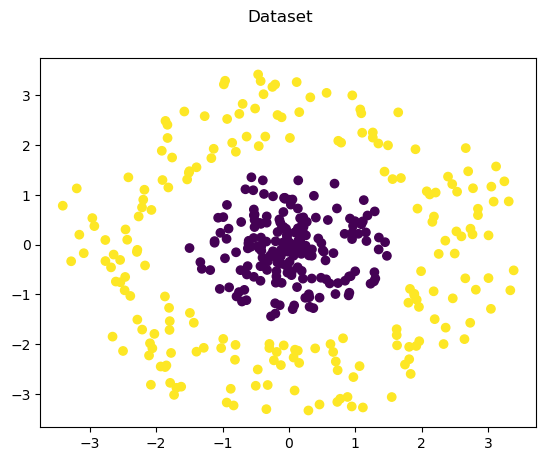

In [11]:
fig,ax = plt.subplots()
ax.scatter(x=X[:,0],y=X[:,1],c=Y[:,0])
fig.suptitle("Dataset")
plt.show()

In [12]:
BS = 8

trainset = TensorDataset(torch.tensor(X,dtype=torch.float32),torch.tensor(Y,dtype=torch.float32))
trainloader = DataLoader(trainset,batch_size=BS,shuffle=False)

In [13]:
LR = 10**-2
EP = 200

net = RBFNeuralNetwork(
    in_features=2,
    n_prototypes=1,
    n_classes=1
).cuda()
opt = torch.optim.SGD(params=net.parameters(),lr=LR)
criterion = nn.BCEWithLogitsLoss()

In [14]:
from utils import get_n_params
print(f"Number of trainable parameters: {get_n_params(net)}")

Number of trainable parameters: 5


In [15]:
trainloss,_ = train_classifier(
    net,
    opt,
    trainloader,
    trainloader,
    criterion,
    EP,
    model_name="rbfnn"
)

[1,    10] loss: 0.724
[1,    20] loss: 0.805
[1,    30] loss: 0.783
[1,    40] loss: 0.791
[1,    50] loss: 0.785
Validation Loss decreased, Saving
[2,    10] loss: 0.707
[2,    20] loss: 0.780
[2,    30] loss: 0.760
[2,    40] loss: 0.767
[2,    50] loss: 0.762
Validation Loss decreased, Saving
[3,    10] loss: 0.693
[3,    20] loss: 0.758
[3,    30] loss: 0.741
[3,    40] loss: 0.748
[3,    50] loss: 0.743
Validation Loss decreased, Saving
[4,    10] loss: 0.682
[4,    20] loss: 0.740
[4,    30] loss: 0.725
[4,    40] loss: 0.731
[4,    50] loss: 0.727
Validation Loss decreased, Saving
[5,    10] loss: 0.673
[5,    20] loss: 0.725
[5,    30] loss: 0.712
[5,    40] loss: 0.717
[5,    50] loss: 0.713
Validation Loss decreased, Saving
[6,    10] loss: 0.665
[6,    20] loss: 0.712
[6,    30] loss: 0.700
[6,    40] loss: 0.704
[6,    50] loss: 0.701
Validation Loss decreased, Saving
[7,    10] loss: 0.658
[7,    20] loss: 0.700
[7,    30] loss: 0.689
[7,    40] loss: 0.694
[7,    50] los

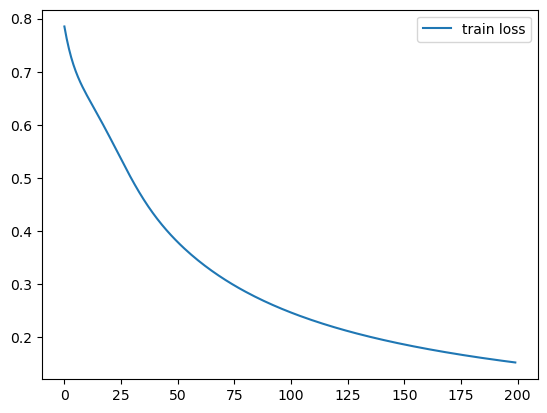

In [16]:
plt.plot(trainloss,label="train loss")
plt.legend()
plt.show()

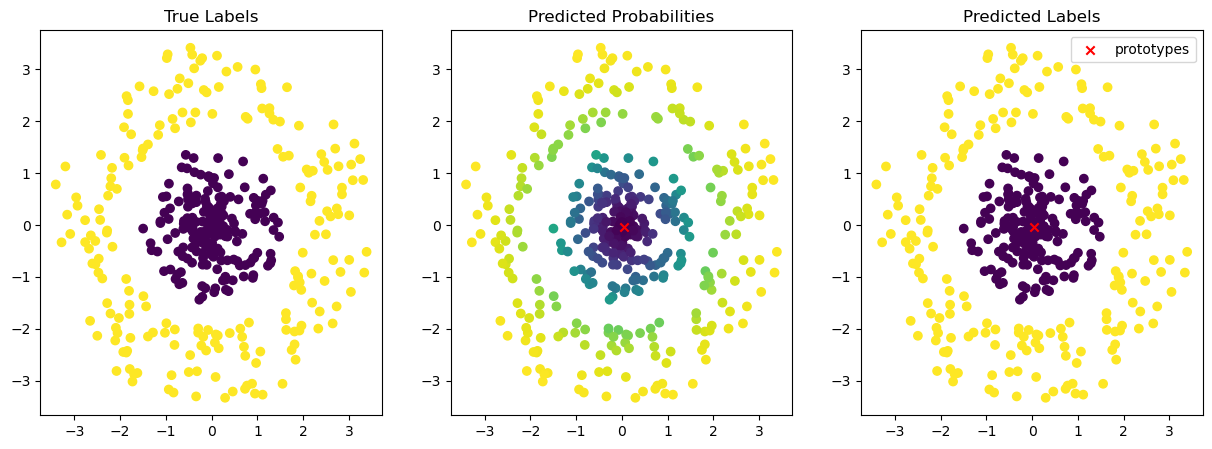

In [17]:
Y_prob = net(torch.tensor(X,dtype=torch.float32).cuda()).cpu().detach()
Y_pred = torch.clone(Y_prob)
Y_pred[Y_pred>=0.5] = torch.ones_like(Y_pred[Y_pred>=0.5])
Y_pred[Y_pred<0.5] = torch.zeros_like(Y_pred[Y_pred<0.5])

prototypes = net.proto[0,...].cpu().detach()
fig,ax = plt.subplots(1,3)
fig.set_size_inches(15,5)
ax[0].scatter(x=X[:,0],y=X[:,1],c=Y)
ax[0].set_title("True Labels")
ax[1].scatter(x=X[:,0],y=X[:,1],c=Y_prob)
ax[1].scatter(x=prototypes[:,0],y=prototypes[:,1],c="r",marker="x",label="prototypes")
ax[1].set_title("Predicted Probabilities")
ax[2].scatter(x=X[:,0],y=X[:,1],c=Y_pred)
ax[2].scatter(x=prototypes[:,0],y=prototypes[:,1],c="r",marker="x",label="prototypes")
ax[2].set_title("Predicted Labels")
plt.legend()
plt.show()